# Credit Card Fraud Detection Using Isolation Forest


### Mathematical Formulation
For a sample **x**, the anomaly score is:
```s(x, n) = 2^(-E(h(x)) / c(n))```
Where:
- `E(h(x))` = average path length over ensemble of trees
- `c(n)` = average path length of unsuccessful search in BST (normalization constant)
- `c(n) = 2H(n-1) - 2(n-1)/n`, where `H(i)` is harmonic number
**Interpretation:**
- `s(x) → 1`: Strong anomaly (short path)
- `s(x) → 0.5`: Normal point (expected path for random data)
- `s(x) → 0`: Very normal (long path, deep in tree)

### Advantages for Fraud Detection

1. **Handles Imbalanced Data**: No need for class balancing
2. **Unsupervised Nature**: Can detect novel fraud patterns not in training
3. **Computational Efficiency**: O(t×ψ×log(ψ)) where t=trees, ψ=subsample size
4. **Low Memory**: Small subsample size (typically 256) regardless of dataset size
5. **Feature Independence**: Works well with mixed feature types (PCA components + engineered features)

Libraries and Setup

In [5]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    precision_recall_curve, auc, confusion_matrix
)

# Custom evaluator
from evaluation import FraudEvaluationMetrics

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


Data Loading

In [6]:
# Load the full dataset (replace with actual path)
df = pd.read_csv('creditcard_fe.csv')  # Full feature-engineered dataset

print(f"Dataset Shape: {df.shape}")
print(f"\nClass Distribution:")
print(df['Class'].value_counts())
print(f"\nClass Balance: {df['Class'].value_counts(normalize=True)}")

# Verify columns
print(f"\nAvailable Features ({len(df.columns)}):")
print(df.columns.tolist())

Dataset Shape: (284807, 37)

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Class Balance: Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Available Features (37):
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'Hour', 'Hour_sin', 'Day', 'log_Amount', 'Time_bin', 'Amount_bin']


## Feature Selection for Isolation Forest

### Theoretical Justification for Feature Selection
**Why Feature Selection Matters for IF:**
1. **Curse of Dimensionality**: While IF is more robust than distance-based methods, too many irrelevant features can dilute isolation effectiveness
2. **Random Feature Selection**: IF samples features randomly at each split - irrelevant features reduce discrimination power
3. **Computational Efficiency**: Fewer features = faster training and prediction**Selection Strategy:**- Remove highly correlated features (correlation > 0.9) to reduce redundancy- Retain features with high variance (anomalies often show extreme values)- Keep domain-relevant features (V11, V14 shown to be good fraud indicators)

## Correlation Analysis

Initial feature count: 35

Highly correlated features to drop (r > 0.95): ['Time_bin']
Count: 1


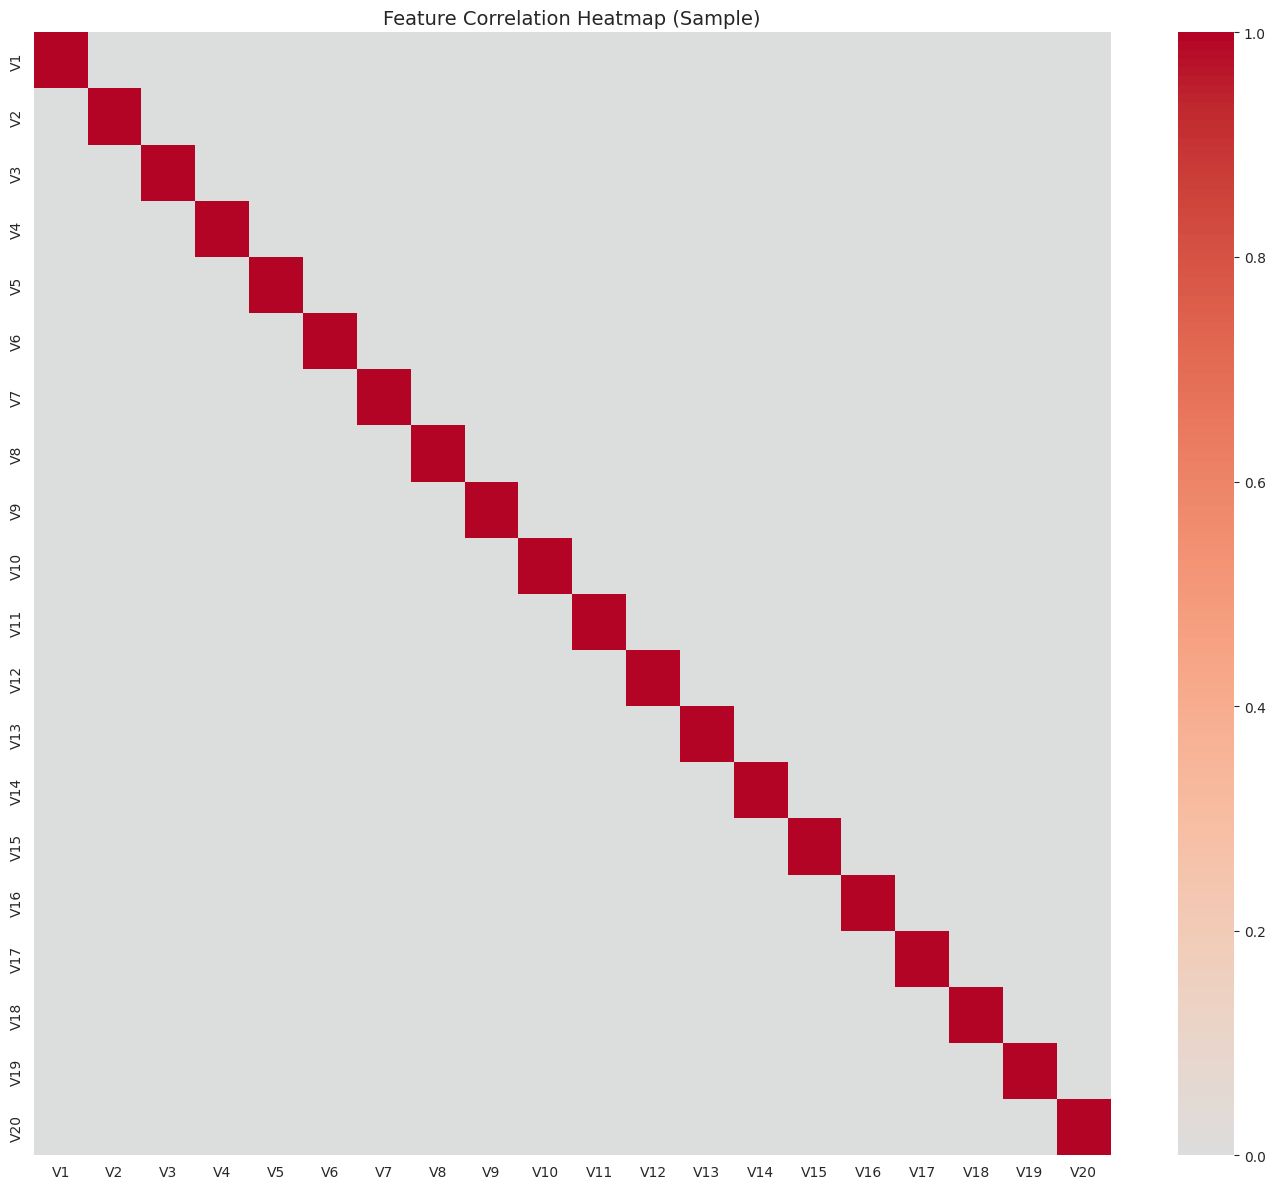

In [7]:
# Separate features and target
feature_cols = [col for col in df.columns if col not in ['Class', 'Time']]
X = df[feature_cols]
y = df['Class']

print(f"Initial feature count: {len(feature_cols)}")

# Calculate correlation matrix
corr_matrix = X.corr().abs()

# Find highly correlated features (upper triangle)
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Identify features to drop (correlation > 0.95)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

print(f"\nHighly correlated features to drop (r > 0.95): {to_drop}")
print(f"Count: {len(to_drop)}")

# Visualize correlation heatmap (sample subset for visibility)
plt.figure(figsize=(14, 12))
sample_features = X.columns[:20]  # First 20 features for visualization
sns.heatmap(X[sample_features].corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (Sample)', fontsize=14)
plt.tight_layout()
plt.show()

### Variance Analysis

In [8]:
# Calculate variance for each feature
variances = X.var().sort_values(ascending=False)

print("Top 10 features by variance:")
print(variances.head(10))

print("\nBottom 10 features by variance:")
print(variances.tail(10))

# Remove low-variance features (variance < 0.01)
low_var_features = variances[variances < 0.01].index.tolist()
print(f"\nLow variance features (var < 0.01): {low_var_features}")

Top 10 features by variance:
Amount        62560.069046
Hour             34.057197
log_Amount        5.275951
V1                3.836489
V2                2.726820
V3                2.299029
V4                2.004684
V5                1.905081
V6                1.774946
V7                1.530401
dtype: float64

Bottom 10 features by variance:
V21         0.539526
V22         0.526643
Hour_sin    0.423201
V23         0.389951
V24         0.366808
V25         0.271731
Day         0.249931
V26         0.232543
V27         0.162919
V28         0.108955
dtype: float64

Low variance features (var < 0.01): []


### Final Feature Selection

In [9]:
# Combine all features to drop
features_to_drop = list(set(to_drop + low_var_features))

# Apply feature selection
X_selected = X.drop(columns=features_to_drop, errors='ignore')

print(f"\n=== FEATURE SELECTION SUMMARY ===")
print(f"Original features: {len(feature_cols)}")
print(f"Features dropped: {len(features_to_drop)}")
print(f"Final features: {len(X_selected.columns)}")
print(f"Reduction: {100 * len(features_to_drop) / len(feature_cols):.1f}%")

print(f"\nSelected features:")
print(X_selected.columns.tolist())


=== FEATURE SELECTION SUMMARY ===
Original features: 35
Features dropped: 1
Final features: 34
Reduction: 2.9%

Selected features:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour', 'Hour_sin', 'Day', 'log_Amount', 'Amount_bin']


## Train-Test Split with Stratification

In [10]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

# Calculate actual contamination rate
actual_contamination = y_train.sum() / len(y_train)
print(f"\nActual contamination in training: {actual_contamination:.4f} ({actual_contamination*100:.2f}%)")

Training set: (199364, 34)
Test set: (85443, 34)

Training class distribution:
Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

Test class distribution:
Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64

Actual contamination in training: 0.0017 (0.17%)


## Hyperparameter Tuning with StratifiedKFold


In [11]:
# Define hyperparameter grid based on research and best practices
param_grid = {
    'n_estimators': [100, 150, 200, 300],  # Number of trees
    'max_samples': [256, 512, 'auto'],     # Subsample size (256 is standard)
    'contamination': [0.001, 0.002, 0.005, 0.01],  # Expected fraud rate
    'max_features': [0.5, 0.7, 0.9, 1.0],  # Fraction of features per split
    'bootstrap': [True, False]             # Bootstrap sampling
}

print("Hyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations: {total_combinations}")

Hyperparameter Grid:
  n_estimators: [100, 150, 200, 300]
  max_samples: [256, 512, 'auto']
  contamination: [0.001, 0.002, 0.005, 0.01]
  max_features: [0.5, 0.7, 0.9, 1.0]
  bootstrap: [True, False]

Total combinations: 384


### Custom Validation Function

In [12]:
def validate_isolation_forest(X_train, y_train, params, n_splits=5, random_state=42):
    """
    Validate Isolation Forest using StratifiedKFold cross-validation.

    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training labels
    params : dict
        Hyperparameters for IsolationForest
    n_splits : int
        Number of CV folds
    random_state : int
        Random seed

    Returns:
    --------
    dict : Validation metrics (mean across folds)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize metrics storage
    fold_metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'total_cost': [],
        'pr_auc': []
    }

    # Initialize custom evaluator
    evaluator = FraudEvaluationMetrics(cost_fp=110, cost_fn=540)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        # Split data
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]

        # Train model (fit on normal transactions only is common, but we use all)
        model = IsolationForest(**params, random_state=random_state)
        model.fit(X_fold_train)

        # Predict (-1 for anomaly, 1 for normal)
        predictions = model.predict(X_fold_val)
        # Convert to binary (1 for fraud, 0 for normal)
        y_pred = (predictions == -1).astype(int)

        # Get anomaly scores (more negative = more anomalous)
        scores = -model.score_samples(X_fold_val)  # Negate for PR curve

        # Calculate metrics
        metrics = evaluator.calculate_metrics(y_fold_val, y_pred, scores)

        # Store metrics
        fold_metrics['precision'].append(metrics['precision'])
        fold_metrics['recall'].append(metrics['recall'])
        fold_metrics['f1'].append(2 * metrics['precision'] * metrics['recall'] /
                                  (metrics['precision'] + metrics['recall'] + 1e-10))
        fold_metrics['total_cost'].append(metrics['total_cost'])
        fold_metrics['pr_auc'].append(metrics['pr_auc'] if metrics['pr_auc'] is not None else 0)

    # Calculate mean metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items()}
    mean_metrics['std_total_cost'] = np.std(fold_metrics['total_cost'])

    return mean_metrics

print("✓ Validation function defined")

✓ Validation function defined


### Grid Search

In [13]:
from itertools import product
import time

# Perform grid search
print("Starting hyperparameter tuning with StratifiedKFold CV...")
print("=" * 70)

results = []
start_time = time.time()

# Create parameter combinations
param_names = list(param_grid.keys())
param_values = [param_grid[name] for name in param_names]

# Iterate through all combinations
for i, values in enumerate(product(*param_values)):
    params = dict(zip(param_names, values))

    # Progress update every 10 iterations
    if i % 10 == 0:
        elapsed = time.time() - start_time
        print(f"\nProgress: {i}/{total_combinations} ({100*i/total_combinations:.1f}%) | "
              f"Elapsed: {elapsed:.1f}s")

    try:
        # Validate this parameter set
        metrics = validate_isolation_forest(X_train, y_train, params, n_splits=5)

        # Store results
        result = params.copy()
        result.update(metrics)
        results.append(result)

    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        continue

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by total cost (lower is better)
results_df = results_df.sort_values('total_cost')

print(f"\n{'='*70}")
print(f"Grid search completed in {time.time() - start_time:.1f} seconds")


Starting hyperparameter tuning with StratifiedKFold CV...

Progress: 0/384 (0.0%) | Elapsed: 0.0s

Progress: 10/384 (2.6%) | Elapsed: 140.7s

Progress: 20/384 (5.2%) | Elapsed: 288.3s

Progress: 30/384 (7.8%) | Elapsed: 434.4s

Progress: 40/384 (10.4%) | Elapsed: 579.7s

Progress: 50/384 (13.0%) | Elapsed: 733.4s

Progress: 60/384 (15.6%) | Elapsed: 889.0s

Progress: 70/384 (18.2%) | Elapsed: 1040.0s

Progress: 80/384 (20.8%) | Elapsed: 1176.6s

Progress: 90/384 (23.4%) | Elapsed: 1316.7s

Progress: 100/384 (26.0%) | Elapsed: 1488.1s

Progress: 110/384 (28.6%) | Elapsed: 1703.6s

Progress: 120/384 (31.2%) | Elapsed: 1911.9s

Progress: 130/384 (33.9%) | Elapsed: 2131.0s

Progress: 140/384 (36.5%) | Elapsed: 2356.9s

Progress: 150/384 (39.1%) | Elapsed: 2587.5s

Progress: 160/384 (41.7%) | Elapsed: 2808.1s

Progress: 170/384 (44.3%) | Elapsed: 3014.6s

Progress: 180/384 (46.9%) | Elapsed: 3228.5s

Progress: 190/384 (49.5%) | Elapsed: 3447.5s

Progress: 200/384 (52.1%) | Elapsed: 3706.0s


### Analyze Best Parameters

In [14]:
# Display top 10 configurations
print("\nTop 10 Configurations by Total Cost:")
print("=" * 70)
top_10 = results_df.head(10)[['n_estimators', 'max_samples', 'contamination',
                                'max_features', 'bootstrap', 'total_cost',
                                'precision', 'recall', 'pr_auc']]
print(top_10.to_string())

# Best parameters
best_params = results_df.iloc[0][param_names].to_dict()
print(f"\n{'='*70}")
print("BEST HYPERPARAMETERS:")
print("=" * 70)
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Validation Metrics:")
print(f"  Total Cost: ${results_df.iloc[0]['total_cost']:,.0f}")
print(f"  Precision: {results_df.iloc[0]['precision']:.4f}")
print(f"  Recall: {results_df.iloc[0]['recall']:.4f}")
print(f"  F1-Score: {results_df.iloc[0]['f1']:.4f}")
print(f"  PR-AUC: {results_df.iloc[0]['pr_auc']:.4f}")


Top 10 Configurations by Total Cost:
     n_estimators max_samples  contamination  max_features  bootstrap  total_cost  precision    recall    pr_auc
328           300         512          0.002           0.5       True     30694.0   0.297675  0.334101  0.206535
329           300         512          0.002           0.5      False     30758.0   0.296773  0.331117  0.201217
43            100         512          0.002           0.7      False     30964.0   0.281873  0.342754  0.175670
42            100         512          0.002           0.7       True     30984.0   0.282807  0.339855  0.172693
331           300         512          0.002           0.7      False     31090.0   0.284262  0.334143  0.187749
132           150         512          0.001           0.9       True     31108.0   0.402947  0.232438  0.205304
140           150         512          0.002           0.9       True     31128.0   0.288718  0.325448  0.205304
320           300         512          0.001           0.5

### Visualize Hyperparameter Impact

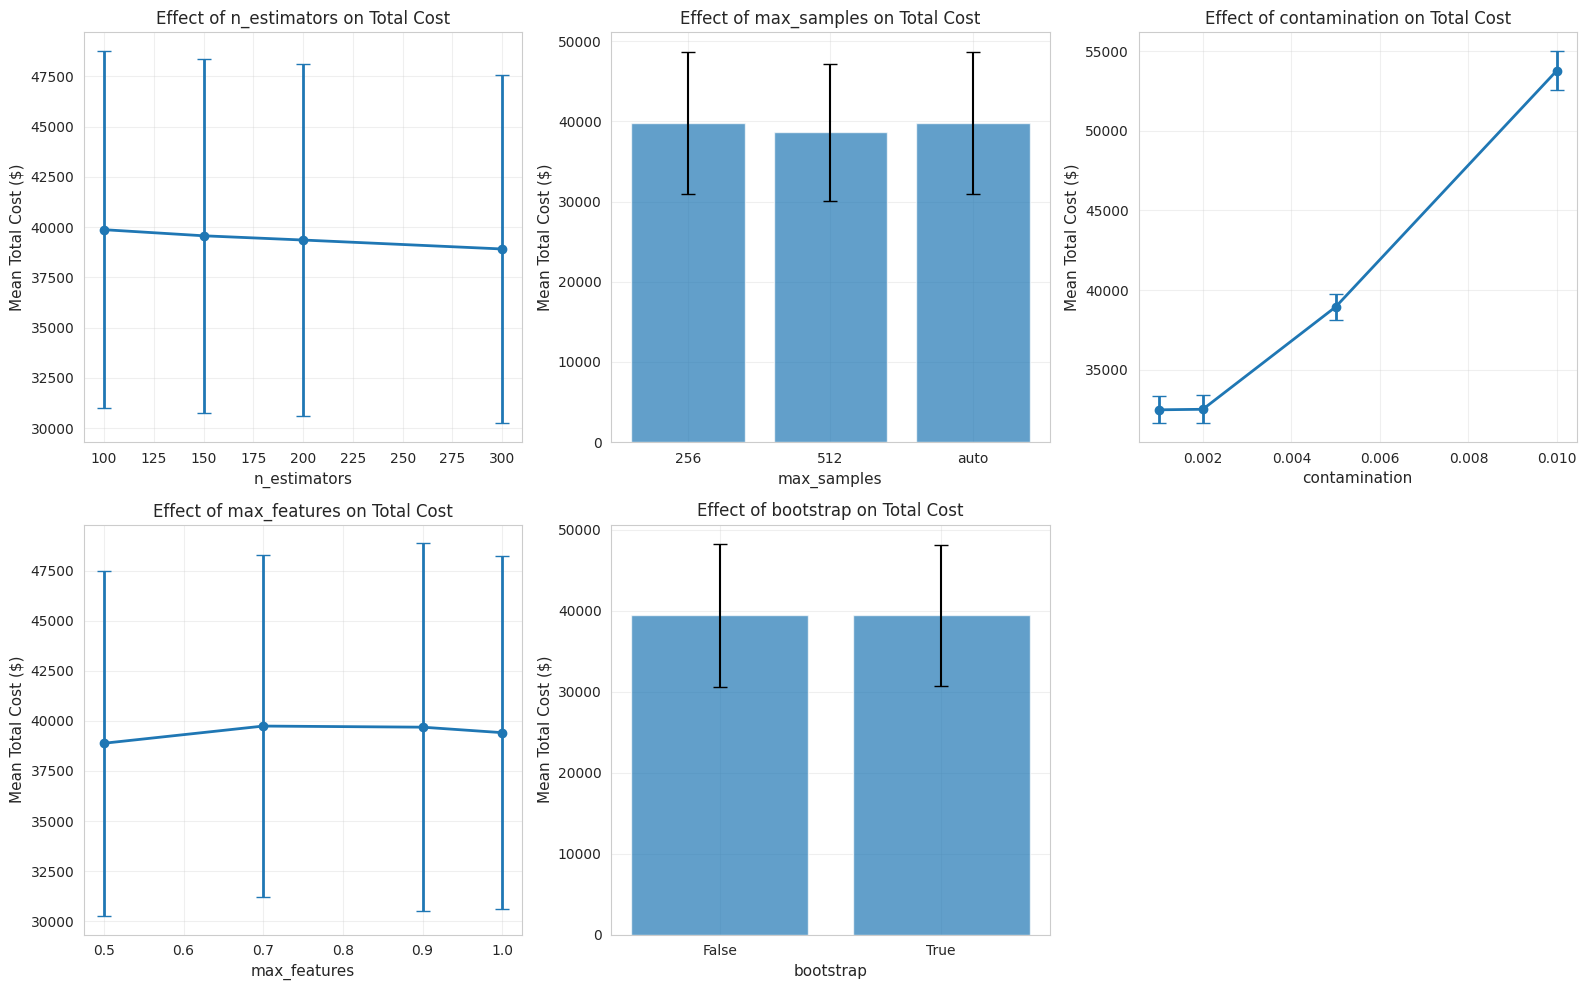

In [17]:
# Plot parameter effects on total cost
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

params_to_plot = ['n_estimators', 'max_samples', 'contamination',
                   'max_features', 'bootstrap']

for idx, param in enumerate(params_to_plot):
    ax = axes[idx]

    # Group by parameter and calculate mean cost
    grouped = results_df.groupby(param)['total_cost'].agg(['mean', 'std']).reset_index()

    if param in ['bootstrap', 'max_samples']: # Handle 'max_samples' as categorical
        # Categorical
        ax.bar(grouped[param].astype(str), grouped['mean'],
               yerr=grouped['std'], capsize=5, alpha=0.7)
    else:
        # Numerical
        ax.errorbar(grouped[param], grouped['mean'], yerr=grouped['std'],
                   marker='o', capsize=5, linewidth=2)

    ax.set_xlabel(param, fontsize=11)
    ax.set_ylabel('Mean Total Cost ($)', fontsize=11)
    ax.set_title(f'Effect of {param} on Total Cost', fontsize=12)
    ax.grid(alpha=0.3)

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Train Final Model with Best Parameters

In [18]:
# Train final model on full training set with best hyperparameters
print("Training final model with best hyperparameters...")
print("=" * 70)

final_model = IsolationForest(**best_params, random_state=RANDOM_STATE)
final_model.fit(X_train)

print("✓ Model training complete")

# Generate predictions on test set
y_test_pred_labels = final_model.predict(X_test)
y_test_pred = (y_test_pred_labels == -1).astype(int)  # 1=fraud, 0=normal

# Get anomaly scores
y_test_scores = -final_model.score_samples(X_test)  # More negative = more anomalous

print(f"\nTest Set Predictions:")
print(f"  Predicted frauds: {y_test_pred.sum()}")
print(f"  Predicted normal: {(y_test_pred == 0).sum()}")

Training final model with best hyperparameters...
✓ Model training complete

Test Set Predictions:
  Predicted frauds: 152
  Predicted normal: 85291


## Model Evaluation

In [19]:
# Initialize evaluator
evaluator = FraudEvaluationMetrics(cost_fp=110, cost_fn=540)

# Calculate all metrics
test_metrics = evaluator.calculate_metrics(y_test, y_test_pred, y_test_scores)

print("\n" + "="*70)
print("TEST SET EVALUATION METRICS")
print("="*70)
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"PR-AUC:          {test_metrics['pr_auc']:.4f}")
print(f"Total Cost:      ${test_metrics['total_cost']:,}")
print(f"False Positives: {test_metrics['false_positives']}")
print(f"False Negatives: {test_metrics['false_negatives']}")


TEST SET EVALUATION METRICS
Precision:       0.2697
Recall:          0.2770
PR-AUC:          0.1906
Total Cost:      $69,990
False Positives: 111
False Negatives: 107


### Confusion Matrix

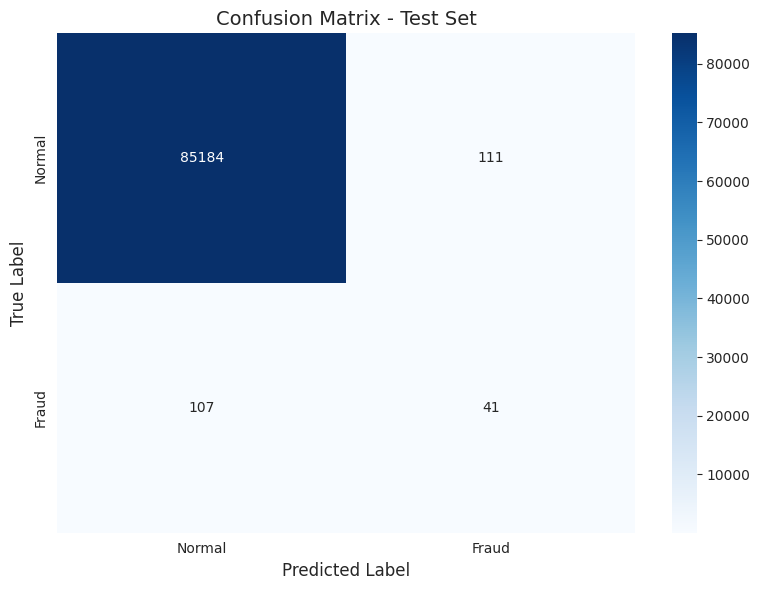


Confusion Matrix Breakdown:
  True Negatives:  85,184
  False Positives: 111
  False Negatives: 107
  True Positives:  41


In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Test Set', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives:  {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives:  {cm[1,1]:,}")

### Precision-Recall Curve

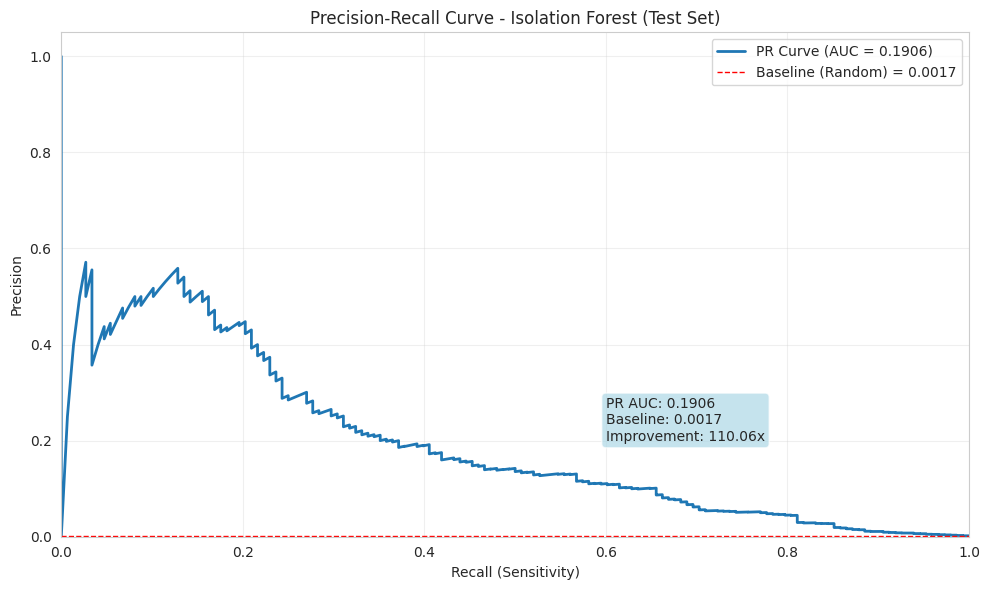

PR-AUC Score: 0.1906


In [21]:
# Plot PR curve using custom evaluator
pr_auc = evaluator.plot_pr_curve(
    y_test,
    y_test_scores,
    title="Precision-Recall Curve - Isolation Forest (Test Set)",
    figsize=(10, 6)
)

print(f"PR-AUC Score: {pr_auc:.4f}")

### Business  Cost Analysis

In [28]:
# Detailed business cost analysis
cost_results = evaluator.business_cost_analysis(
    y_test,
    y_test_pred,
    logistic_baseline_cost=None  # Can add baseline for comparison
)

=== BUSINESS COST ANALYSIS ===
False Positive Cost (FP × 110): 12210
False Negative Cost (FN × 540): 57780
Total Cost: $69990
Baseline Cost (No Detection): $79920
Cost Savings vs No Detection: $9930 (12.42%)
False Positives: 111
False Negatives: 107
True Positives: 41
True Negatives: 85184


### Score Distribution Analysis

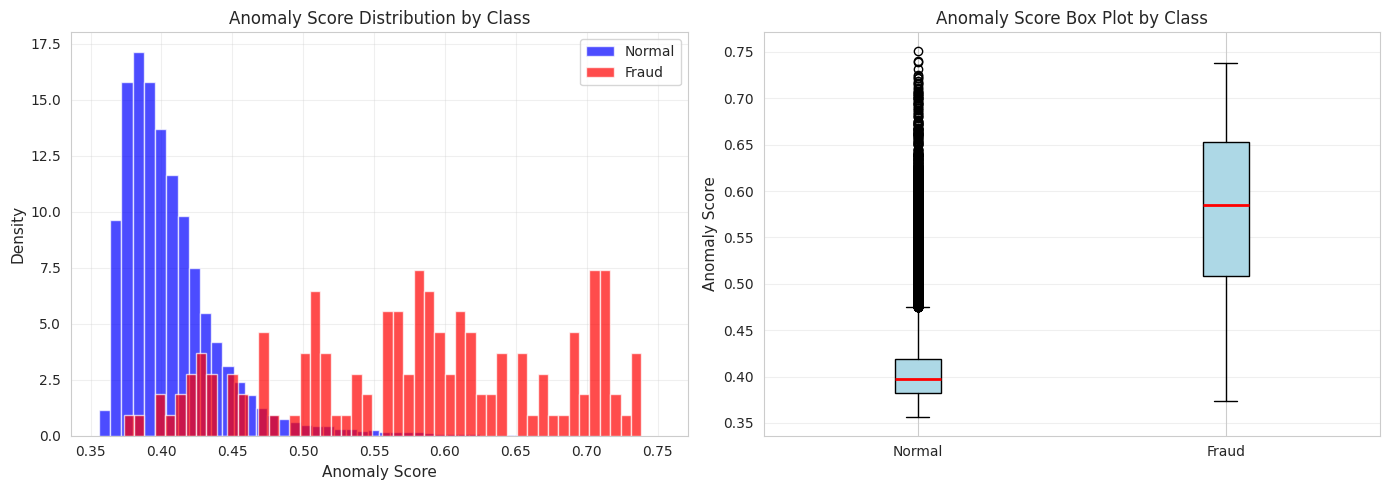

In [29]:
# Analyze anomaly score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score distribution by class
axes[0].hist(y_test_scores[y_test == 0], bins=50, alpha=0.7,
             label='Normal', density=True, color='blue')
axes[0].hist(y_test_scores[y_test == 1], bins=50, alpha=0.7,
             label='Fraud', density=True, color='red')
axes[0].set_xlabel('Anomaly Score', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Anomaly Score Distribution by Class', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
data_to_plot = [y_test_scores[y_test == 0], y_test_scores[y_test == 1]]
axes[1].boxplot(data_to_plot, labels=['Normal', 'Fraud'], patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Anomaly Score', fontsize=11)
axes[1].set_title('Anomaly Score Box Plot by Class', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Results Export

In [30]:
import pickle
import json
import os

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Save the trained model
model_filename = 'isolation_forest_best_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"✓ Model saved to {model_filename}")

# Save selected features
features_filename = 'selected_features.json'
with open(features_filename, 'w') as f:
    json.dump(X_selected.columns.tolist(), f, indent=2)
print(f"✓ Selected features saved to {features_filename}")

# Save best hyperparameters
params_filename = 'best_hyperparameters.json'
with open(params_filename, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"✓ Best parameters saved to {params_filename}")

# Save evaluation results using custom evaluator
results_save = evaluator.save_results(
    cost_results,
    save_path='results/isolation_forest_results.json'
)
print(f"✓ Evaluation results saved")

✓ Model saved to isolation_forest_best_model.pkl
✓ Selected features saved to selected_features.json
✓ Best parameters saved to best_hyperparameters.json

Results saved to: results/isolation_forest_results.json
Total Cost: $69,990
✓ Evaluation results saved


## Summary

In [31]:
print("\n" + "="*70)
print("ISOLATION FOREST - CREDIT CARD FRAUD DETECTION")
print("FINAL SUMMARY")
print("="*70)

print(f"\n1. DATASET CHARACTERISTICS")
print(f"   - Total samples: {len(df):,}")
print(f"   - Fraud rate: {actual_contamination*100:.3f}%")
print(f"   - Features after selection: {len(X_selected.columns)}")

print(f"\n2. BEST HYPERPARAMETERS")
for param, value in best_params.items():
    print(f"   - {param}: {value}")

print(f"\n3. TEST SET PERFORMANCE")
print(f"   - Precision: {test_metrics['precision']:.4f}")
print(f"   - Recall: {test_metrics['recall']:.4f}")
print(f"   - PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"   - Total Cost: ${test_metrics['total_cost']:,}")
print(f"   - False Positives: {test_metrics['false_positives']}")
print(f"   - False Negatives: {test_metrics['false_negatives']}")

print(f"\n4. BUSINESS IMPACT")
baseline_cost_no_detection = y_test.sum() * 540  # All frauds missed
cost_reduction = baseline_cost_no_detection - test_metrics['total_cost']
print(f"   - Baseline cost (no detection): ${baseline_cost_no_detection:,}")
print(f"   - Cost with IF detection: ${test_metrics['total_cost']:,}")
print(f"   - Cost savings: ${cost_reduction:,}")
print(f"   - Savings rate: {100*cost_reduction/baseline_cost_no_detection:.2f}%")

print("\n" + "="*70)


ISOLATION FOREST - CREDIT CARD FRAUD DETECTION
FINAL SUMMARY

1. DATASET CHARACTERISTICS
   - Total samples: 284,807
   - Fraud rate: 0.173%
   - Features after selection: 34

2. BEST HYPERPARAMETERS
   - n_estimators: 300
   - max_samples: 512
   - contamination: 0.002
   - max_features: 0.5
   - bootstrap: True

3. TEST SET PERFORMANCE
   - Precision: 0.2697
   - Recall: 0.2770
   - PR-AUC: 0.1906
   - Total Cost: $69,990
   - False Positives: 111
   - False Negatives: 107

4. BUSINESS IMPACT
   - Baseline cost (no detection): $79,920
   - Cost with IF detection: $69,990
   - Cost savings: $9,930
   - Savings rate: 12.42%

